In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv

## Section 1: Model Comparison

In [2]:
for m in range(4):
    
    ## Load ppc.
    ppc = read_csv(os.path.join('stan_results', f'1pl_m{m+1}_ppc.csv'))
    if np.any(ppc.k_u > 0.5): print(f'[m{m}] WARNING: k-hat measures above 0.5.')
        
    ## Model comparison.
    louo = ppc.louo.sum()
    loco = ppc.groupby('subject').loco.mean().sum()
    pwaic_u = ppc.pwaic_u.sum()
    pwaic_c = ppc.groupby('subject').pwaic_c.mean().sum()
    
    print('m%s:  %0.3f | %0.3f | %0.3f | %0.3f' %(m+1, louo, loco, pwaic_u, pwaic_c))

m1:  -13682.584 | -13592.691 | 1155.670 | 115.556
m2:  -13312.044 | -13210.953 | 1190.392 | 169.193
m3:  -13532.890 | -13436.319 | 1234.753 | 208.260
m4:  -13158.729 | -13050.601 | 1299.683 | 295.889


In [3]:
from itertools import combinations

for a, b in combinations([1,2,3,4],2):
    
    ## Load data.
    df1 = read_csv(os.path.join('stan_results', f'1pl_m{a}_ppc.csv'))
    df2 = read_csv(os.path.join('stan_results', f'1pl_m{b}_ppc.csv'))
    
    arr = df2.groupby('subject').loco.mean() - df1.groupby('subject').loco.mean()
    
    ## Compute stats.
    N = df1.subject.nunique()
    mu = np.sum(arr)
    se = np.std(arr) * np.sqrt(N)
    
    print(f'm{b} - m{a}: %0.3f (%0.3f)' %(mu, se))

m2 - m1: 381.738 (26.265)
m3 - m1: 156.372 (18.198)
m4 - m1: 542.090 (32.221)
m3 - m2: -225.366 (31.970)
m4 - m2: 160.352 (18.908)
m4 - m3: 385.718 (26.964)


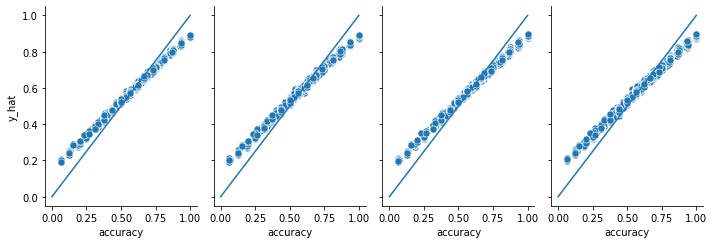

In [4]:
fig, axes = plt.subplots(1,4,figsize=(10,3.5),sharex=True,sharey=True)
agg = {'accuracy':'mean', 'y_hat':'mean'}

for m, ax in enumerate(axes.flatten()):
    
    ppc = read_csv(os.path.join('stan_results', f'1pl_m{m+1}_ppc.csv'))
    gb = ppc.groupby('subject').agg(agg)
    
    sns.scatterplot(x='accuracy', y='y_hat', data=gb, s=50, ax=ax)
    ax.plot([0,1],[0,1])
    
sns.despine()
plt.tight_layout()

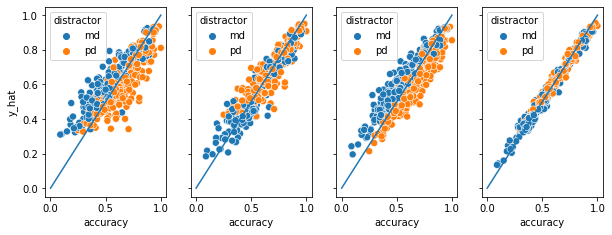

In [5]:
fig, axes = plt.subplots(1,4,figsize=(10,3.5),sharex=True,sharey=True)
agg = {'accuracy':'mean', 'y_hat':'mean'}

for m, ax in enumerate(axes.flatten()):
    
    ppc = read_csv(os.path.join('stan_results', f'1pl_m{m+1}_ppc.csv'))
    gb = ppc.groupby(['item','distractor','test_form']).agg(agg).reset_index()
    gb['delta'] = gb['accuracy'] - gb['y_hat']
    
    sns.scatterplot(x='accuracy', y='y_hat', data=gb, hue='distractor', s=50, ax=ax)
    ax.plot([0,1],[0,1])

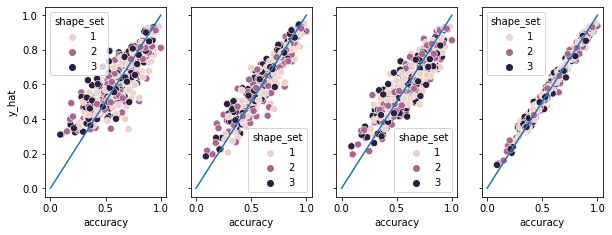

In [6]:
fig, axes = plt.subplots(1,4,figsize=(10,3.5),sharex=True,sharey=True)
agg = {'accuracy':'mean', 'y_hat':'mean'}

for m, ax in enumerate(axes.flatten()):
    
    ppc = read_csv(os.path.join('stan_results',  f'1pl_m{m+1}_ppc.csv'))
    gb = ppc.groupby(['item','distractor','shape_set']).agg(agg).reset_index()
    gb['delta'] = gb['accuracy'] - gb['y_hat']
    
    sns.scatterplot(x='accuracy', y='y_hat', data=gb, hue='shape_set', s=50, ax=ax)
    ax.plot([0,1],[0,1])